# Odor bout rate and return point histogram Sleep paper

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as stats
import scipy.stats as ss
from pylab import *
from scipy.optimize import curve_fit
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.stats import gaussian_kde
from scipy.stats import sem  # Import sem from scipy
from scipy.stats import ranksums

## Normalized bout histogram to plot return point

Data frame from Matlab

0. bout rate
1. fish number
2. bin number
3. preBout X position
4. preBout time in s


In [306]:
# change directory
bout_rates_ctrl=pd.read_csv(r"D:\Olfaction\Preference_index_starved\partial_starvation\patial_starvation\bout_rates_control.csv", header=None)
print(bout_rates_ctrl)

              0   1   2        3         4
0      1.709402  26   1  341.727    17.176
1      2.506266  26   1  340.628    18.160
2      1.930502  26   1  340.579    18.969
3      3.690037  26   1  340.897    19.800
4      2.040816  26   1  341.132    20.403
...         ...  ..  ..      ...       ...
26550  0.173762  14  46  887.673  1629.163
26551  1.841621  14  46  887.682  1816.760
26552  0.670691  14  46  888.513  1838.517
26553  1.216545  15  46  889.538  1053.046
26554  0.061248  15  46  889.267  1054.062

[26555 rows x 5 columns]


In [308]:
# change directory
bout_rates_SD=pd.read_csv(r"D:\Olfaction\Preference_index_starved\partial_starvation\patial_starvation\bout_rates_starved.csv", header=None)
print(bout_rates_SD)

               0   1   2        3         4
0       0.780031   7   1  341.889   821.423
1       0.082488   7   1  341.355   873.570
2       2.481390   7   1  342.080   886.029
3       2.197802   7   1  341.163   886.817
4       0.022897   7   1  340.482   887.617
...          ...  ..  ..      ...       ...
19137   0.413052  28  45  885.278  1557.441
19138   0.015733  28  45  885.278  1560.173
19139  12.987013  10  46  887.733    58.162
19140   0.522193  26  46  889.068   561.993
19141   2.257336  26  46  889.185   564.008

[19142 rows x 5 columns]


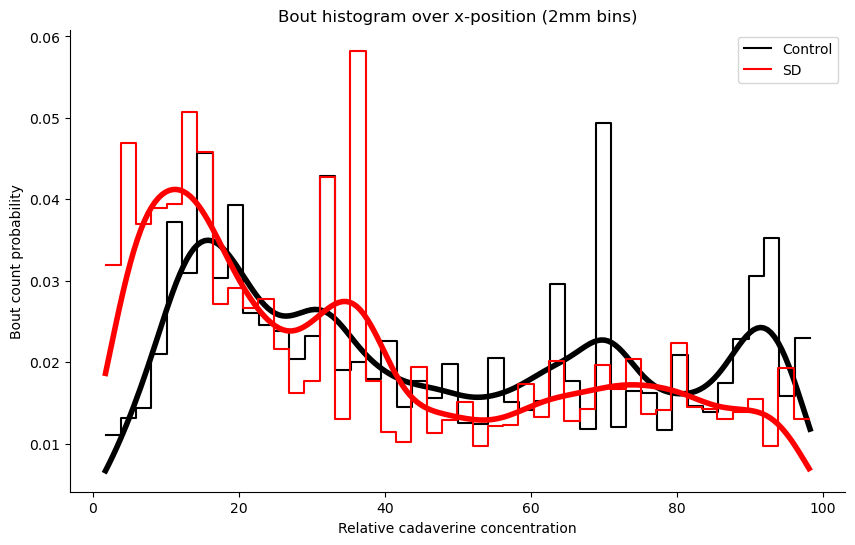

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data1 and data2 are pandas DataFrames
data1 = bout_rates_ctrl
data2 = bout_rates_SD

#convert x values to relative values for cadaverine concentration
preBout_1 = data1[3]
preBout_2=data2[3]
x_min = 330
x_max = 900
normalized_preBout_1 = (preBout_1 - x_min) / (x_max - x_min) * 100
normalized_preBout_2 = (preBout_2 - x_min) / (x_max - x_min) * 100;

# Create a figure
plt.figure(figsize=(10, 6))

# Plot both histograms using histplot ; previously bins: 85, 46bins =2mm per bin
sns.histplot(data=data1, x=normalized_preBout_1, kde=True, bins=46,  color='black',element="step", fill=False, 
             label='Control',stat='probability',
            line_kws = dict(linewidth = 4))
sns.histplot(data=data2, x=normalized_preBout_2, kde=True, bins=46, color='red',element="step", fill=False,
             label='SD',stat='probability',
              line_kws = dict(linewidth = 4))

# Add labels and title
plt.ylabel("Bout count probability")
plt.xlabel("Relative cadaverine concentration")
plt.title("Bout histogram over x-position (2mm bins)")

#plt.ylim(0.0, 0.06)
# Add a legend to distinguish the two distributions
plt.legend()

# Remove the top and right spines for a cleaner look
sns.despine(right=True, bottom=False)

# Save or display the plot
#plt.savefig(r"E:\Olfaction\Preference_index_starved\complete_starvation\Pref_index_starvation_3h\return_point.pdf")
plt.show()


## Bout rates

## New trials!!

bout rate difference calculated by substracting the bout rate 2cm close to odor source from the bout rate far away from odor source.

### Control

#### Bout rates

In [310]:
# Assuming you already loaded the dataframe with appropriate column names:
bout_rates_ctrl.columns = ['bout_rate', 'fish_number', 'bin_number', 'prebout_Xposition', 'prebout_time']

# Create left and right bin subsets
left_df_ctrl = bout_rates_ctrl[bout_rates_ctrl['bin_number'].between(1, 10)]
right_df_ctrl = bout_rates_ctrl[bout_rates_ctrl['bin_number'].between(36, 46)]
print(left_df_ctrl)


# Count total bouts per fish (each row is a bout)
left_bout_counts_ctrl = left_df_ctrl.groupby('fish_number').size().rename("total_bouts_left")
print(left_bout_counts_ctrl)
right_bout_counts_ctrl = right_df_ctrl.groupby('fish_number').size().rename("total_bouts_right")

# Calculate bout rate per fish using 1800s experiment time
left_bout_rates_ctrl = left_bout_counts_ctrl.to_frame()
right_bout_rates_ctrl = right_bout_counts_ctrl.to_frame()

left_bout_rates_ctrl["bout_rate_per_sec_left"] = left_bout_rates_ctrl["total_bouts_left"] / 1800
left_bout_rates_ctrl["bout_rate_per_min_left"] = left_bout_rates_ctrl["bout_rate_per_sec_left"] * 60
print(left_bout_rates_ctrl)

right_bout_rates_ctrl["bout_rate_per_sec_right"] = right_bout_rates_ctrl["total_bouts_right"] / 1800
right_bout_rates_ctrl["bout_rate_per_min_right"] = right_bout_rates_ctrl["bout_rate_per_sec_right"] * 60

# Compute the mean bout rate per fish for left and right
mean_left_bout_rate_min_ctrl = left_bout_rates_ctrl["bout_rate_per_min_left"].mean()
SEM_left_bout_rate_min_ctrl = sem(left_bout_rates_ctrl["bout_rate_per_min_left"])

mean_right_bout_rate_min_ctrl = right_bout_rates_ctrl["bout_rate_per_min_right"].mean()
SEM_right_bout_rate_min_ctrl = sem(right_bout_rates_ctrl["bout_rate_per_min_right"])

# Output results
print("Left side mean bout rate:")
print(f" {mean_left_bout_rate_min_ctrl:.2f} bouts/min +/- {SEM_left_bout_rate_min_ctrl:.4f}")

print("\nRight side mean bout rate:")
print(f" {mean_right_bout_rate_min_ctrl:.2f} bouts/min +/- {SEM_right_bout_rate_min_ctrl:.4f}")

      bout_rate  fish_number  bin_number  prebout_Xposition  prebout_time
0      1.709402           26           1            341.727        17.176
1      2.506266           26           1            340.628        18.160
2      1.930502           26           1            340.579        18.969
3      3.690037           26           1            340.897        19.800
4      2.040816           26           1            341.132        20.403
...         ...          ...         ...                ...           ...
6799   1.360544           34          10            453.187       966.067
6800   0.226091           34          10            446.562      1016.517
6801   1.669449           34          10            442.923      1351.862
6802   5.555556           34          10            443.548      1364.099
6803   2.070393           34          10            451.630      1364.947

[6804 rows x 5 columns]
fish_number
1     488
3     429
4     536
5     341
6     345
7     387
8     234
9    

In [311]:
# check for correctness
left_df_ctrl.loc[left_df_ctrl['fish_number'] == 3]

,bout_rate,fish_number,bin_number,prebout_Xposition,prebout_time
370,0.999001,3,3,363.479,211.882
371,1.605136,3,3,365.073,213.240
372,13.888889,3,3,363.231,214.285
373,1.890359,3,3,362.679,319.024
374,14.084507,3,3,361.778,319.740
...,...,...,...,...,...
6163,0.920810,3,10,449.048,1443.250
6164,1.886792,3,10,441.750,1513.151
6165,0.034815,3,10,448.733,1514.119
6166,4.424779,3,10,441.900,1547.246


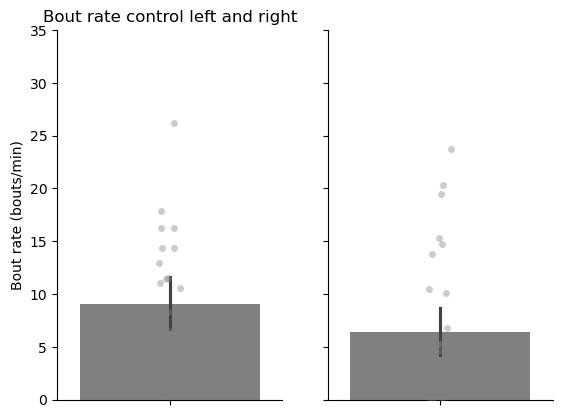

In [312]:
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.barplot(ax=ax1,y=left_bout_rates_ctrl['bout_rate_per_min_left'], color = "grey", orient="v")
ax = sns.stripplot(ax=ax1,y="bout_rate_per_min_left", data=left_bout_rates_ctrl, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=right_bout_rates_ctrl['bout_rate_per_min_right'], color = "grey", orient="v")
ax = sns.stripplot(ax=ax2,y="bout_rate_per_min_right", data=right_bout_rates_ctrl, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax1.set_title("Bout rate control left and right")
ax.set_ylim(0, 35)
ax1.set_ylabel("Bout rate (bouts/min)")
sns.despine(right=True, bottom=False)
fig.savefig(r"D:\Olfaction\Preference_index_starved\partial_starvation\patial_starvation\bout_rate_left_right_control.pdf")

In [313]:
# stats left vs right bout rate
p=ranksums(left_bout_rates_ctrl['bout_rate_per_min_left'], right_bout_rates_ctrl['bout_rate_per_min_right'])
print(f"left vs right: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}")

left vs right: statistic=2.062176, p-value=0.0391909465


#### Bout rate difference


In [314]:
# Merge left and right bout rates for each fish
bout_rate_df_ctrl = pd.merge(left_bout_rates_ctrl, right_bout_rates_ctrl, on='fish_number')
print(bout_rate_df_ctrl)

# Calculate the difference: bout rate right - bout rate left
bout_rate_df_ctrl['bout_rate_difference'] = bout_rate_df_ctrl['bout_rate_per_min_right'] - bout_rate_df_ctrl['bout_rate_per_min_left']
print(bout_rate_df_ctrl)

# Calculate the mean bout rate difference across all fish
mean_bout_rate_difference_ctrl = bout_rate_df_ctrl['bout_rate_difference'].mean()
sem_bout_rate_difference_ctrl = sem(bout_rate_df_ctrl['bout_rate_difference'])

# print results
#print("Mean bout rate difference Control")
print(f" {mean_bout_rate_difference_ctrl:.4f} bouts/min +/- {sem_bout_rate_difference_ctrl:.4f}")

             total_bouts_left  bout_rate_per_sec_left  bout_rate_per_min_left  \
fish_number                                                                     
1                         488                0.271111               16.266667   
3                         429                0.238333               14.300000   
4                         536                0.297778               17.866667   
5                         341                0.189444               11.366667   
6                         345                0.191667               11.500000   
7                         387                0.215000               12.900000   
8                         234                0.130000                7.800000   
11                         16                0.008889                0.533333   
12                        151                0.083889                5.033333   
15                        124                0.068889                4.133333   
16                         6

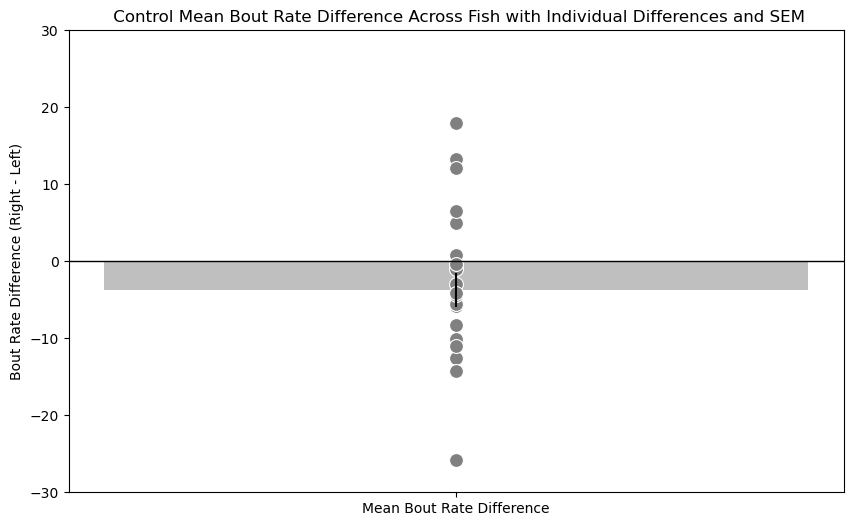

In [315]:
# Plotting
plt.figure(figsize=(10, 6))

# Bar plot: Mean bout rate difference across all fish with error bar for SEM
ax=sns.barplot(x=['Mean Bout Rate Difference'], y=[mean_bout_rate_difference_ctrl], color='grey', yerr=sem_bout_rate_difference_ctrl, alpha=0.5)

# Scatter plot overlay: Individual bout rate differences per fish
ax=sns.scatterplot(x=['Mean Bout Rate Difference'] * len(bout_rate_df_ctrl), y=bout_rate_df_ctrl['bout_rate_difference'], color='grey', s=100)

# Labels and title
plt.ylabel("Bout Rate Difference (Right - Left)")
plt.title(" Control Mean Bout Rate Difference Across Fish with Individual Differences and SEM")

plt.ylim(-30,30)
plt.axhline(y=0, color='black', linewidth=1, linestyle='-')  # Dashed line at y=0

plt.savefig(r"D:\Olfaction\Preference_index_starved\partial_starvation\patial_starvation\boutrateDiff_ctrl.pdf")
plt.show()

### Treatment

In [316]:
# Assuming you already loaded the dataframe with appropriate column names:
bout_rates_SD.columns = ['bout_rate', 'fish_number', 'bin_number', 'prebout_Xposition', 'prebout_time']
print(bout_rates_SD)

# Create left and right bin subsets
left_df_SD = bout_rates_SD[bout_rates_SD['bin_number'].between(1, 10)]
right_df_SD = bout_rates_SD[bout_rates_SD['bin_number'].between(36, 46)]
print(left_df_SD)


# Count total bouts per fish (each row is a bout)
left_bout_counts_SD = left_df_SD.groupby('fish_number').size().rename("total_bouts_left")
print(left_bout_counts_SD)
right_bout_counts_SD = right_df_SD.groupby('fish_number').size().rename("total_bouts_right")

# Calculate bout rate per fish using 1800s experiment time
left_bout_rates_SD = left_bout_counts_SD.to_frame()
right_bout_rates_SD = right_bout_counts_SD.to_frame()

left_bout_rates_SD["bout_rate_per_sec_left"] = left_bout_rates_SD["total_bouts_left"] / 1800
left_bout_rates_SD["bout_rate_per_min_left"] = left_bout_rates_SD["bout_rate_per_sec_left"] * 60
print(left_bout_rates_SD)

right_bout_rates_SD["bout_rate_per_sec_right"] = right_bout_rates_SD["total_bouts_right"] / 1800
right_bout_rates_SD["bout_rate_per_min_right"] = right_bout_rates_SD["bout_rate_per_sec_right"] * 60

# Compute the mean bout rate per fish for left and right
mean_left_bout_rate_min_SD = left_bout_rates_SD["bout_rate_per_min_left"].mean()
SEM_left_bout_rate_min_SD = sem(left_bout_rates_SD["bout_rate_per_min_left"])

mean_right_bout_rate_min_SD = right_bout_rates_SD["bout_rate_per_min_right"].mean()
SEM_right_bout_rate_min_SD= sem(right_bout_rates_SD["bout_rate_per_min_right"])

# Output results
print("Left side mean bout rate:")
print(f" {mean_left_bout_rate_min_SD:.2f} bouts/min +/- {SEM_left_bout_rate_min_SD:.4f}")

print("\nRight side mean bout rate:")
print(f" {mean_right_bout_rate_min_SD:.2f} bouts/min +/- {SEM_right_bout_rate_min_SD:.4f}")

       bout_rate  fish_number  bin_number  prebout_Xposition  prebout_time
0       0.780031            7           1            341.889       821.423
1       0.082488            7           1            341.355       873.570
2       2.481390            7           1            342.080       886.029
3       2.197802            7           1            341.163       886.817
4       0.022897            7           1            340.482       887.617
...          ...          ...         ...                ...           ...
19137   0.413052           28          45            885.278      1557.441
19138   0.015733           28          45            885.278      1560.173
19139  12.987013           10          46            887.733        58.162
19140   0.522193           26          46            889.068       561.993
19141   2.257336           26          46            889.185       564.008

[19142 rows x 5 columns]
      bout_rate  fish_number  bin_number  prebout_Xposition  prebout_time


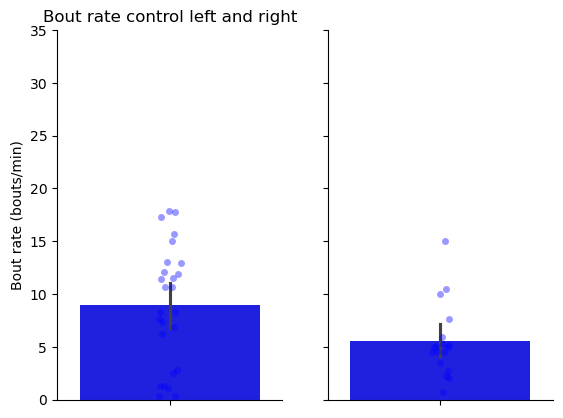

In [326]:
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.barplot(ax=ax1,y=left_bout_rates_SD['bout_rate_per_min_left'], color = "blue", orient="v")
ax = sns.stripplot(ax=ax1,y="bout_rate_per_min_left", data=left_bout_rates_SD, dodge=True, color="blue", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=right_bout_rates_SD['bout_rate_per_min_right'], color = "blue", orient="v")
ax = sns.stripplot(ax=ax2,y="bout_rate_per_min_right", data=right_bout_rates_SD, dodge=True, color="blue", alpha = 0.4,jitter = 0.05)

ax1.set_title("Bout rate control left and right")
ax.set_ylim(0, 35)
ax1.set_ylabel("Bout rate (bouts/min)")
sns.despine(right=True, bottom=False)
fig.savefig(r"D:\Olfaction\Preference_index_starved\partial_starvation\patial_starvation\bout_rate_left_right_SD.pdf")

In [318]:
# stats left vs right bout rate
p=ranksums(left_bout_rates_SD['bout_rate_per_min_left'], right_bout_rates_SD['bout_rate_per_min_right'])
print(f"left vs right: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}")

left vs right: statistic=2.100604, p-value=0.0356757751


In [319]:
# stats control vs treatment left and control vs treatment right
p=ranksums(left_bout_rates_ctrl['bout_rate_per_min_left'], left_bout_rates_SD['bout_rate_per_min_left'])
print(f"control vs treatment low odor: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}") #left

p=ranksums(right_bout_rates_ctrl['bout_rate_per_min_right'], right_bout_rates_SD['bout_rate_per_min_right'])
print(f"control vs treatment high odor: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}") #right


control vs treatment low odor: statistic=-0.207265, p-value=0.8358032840
control vs treatment high odor: statistic=-0.383326, p-value=0.7014781089


In [320]:
print(f"control left n={len(left_bout_rates_ctrl)}, control right n={len(right_bout_rates_ctrl)},t reatment left n={len(left_bout_rates_SD)}, treatment right n={len(right_bout_rates_SD)}")


control left n=25, control right n=30,t reatment left n=26, treatment right n=18


## Bout rate difference

In [327]:
# Merge left and right bout rates for each fish
bout_rate_df_SD = pd.merge(left_bout_rates_SD, right_bout_rates_SD, on='fish_number')
print(bout_rate_df_SD)

# Calculate the difference: bout rate right - bout rate left
bout_rate_df_SD['bout_rate_difference'] = bout_rate_df_SD['bout_rate_per_min_right'] - bout_rate_df_SD['bout_rate_per_min_left']
print(bout_rate_df_SD)

# Calculate the mean bout rate difference across all fish
mean_bout_rate_difference_SD = bout_rate_df_SD['bout_rate_difference'].mean()
sem_bout_rate_difference_SD = sem(bout_rate_df_SD['bout_rate_difference'])

# print results
#print("Mean bout rate difference Control")
print(f" {mean_bout_rate_difference_SD:.4f} bouts/min +/- {sem_bout_rate_difference_SD:.4f}")

             total_bouts_left  bout_rate_per_sec_left  bout_rate_per_min_left  \
fish_number                                                                     
1                           9                0.005000                0.300000   
2                          11                0.006111                0.366667   
3                         536                0.297778               17.866667   
4                         341                0.189444               11.366667   
5                         345                0.191667               11.500000   
6                         387                0.215000               12.900000   
7                         362                0.201111               12.066667   
10                         74                0.041111                2.466667   
13                        532                0.295556               17.733333   
15                        249                0.138333                8.300000   
19                        24

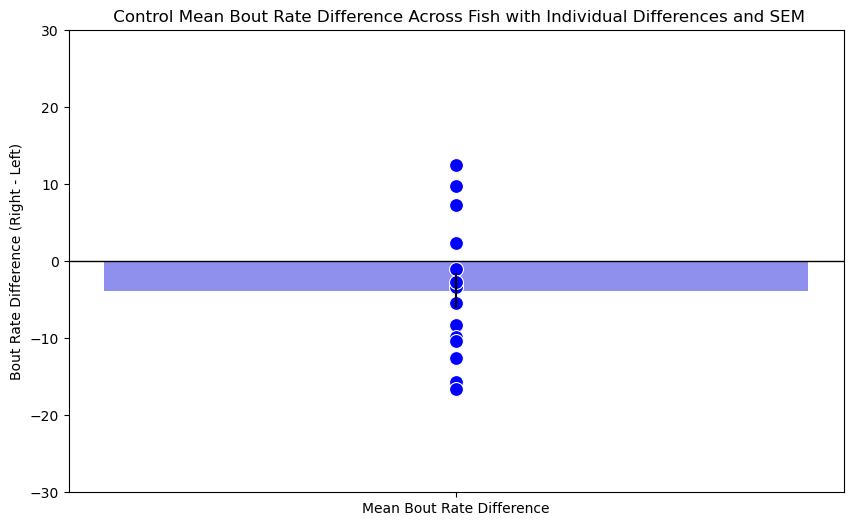

In [328]:
# Plotting
plt.figure(figsize=(10, 6))

# Bar plot: Mean bout rate difference across all fish with error bar for SEM
ax=sns.barplot(x=['Mean Bout Rate Difference'], y=[mean_bout_rate_difference_SD], color='blue', yerr=sem_bout_rate_difference_SD, alpha=0.5)

# Scatter plot overlay: Individual bout rate differences per fish
ax=sns.scatterplot(x=['Mean Bout Rate Difference'] * len(bout_rate_df_SD), y=bout_rate_df_SD['bout_rate_difference'], color='blue', s=100)

# Labels and title
plt.ylabel("Bout Rate Difference (Right - Left)")
plt.title(" Control Mean Bout Rate Difference Across Fish with Individual Differences and SEM")

plt.ylim(-30,30)
plt.axhline(y=0, color='black', linewidth=1, linestyle='-')  # Dashed line at y=0

plt.savefig(r"D:\Olfaction\Preference_index_starved\partial_starvation\patial_starvation\boutrateDiff_starved.pdf")
plt.show()

In [329]:
p=ranksums(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'])
print(f"control vs treatment: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}")

control vs treatment: statistic=-0.030934, p-value=0.9753218468


In [330]:
p=ss.ttest_ind(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'])
print(p)

TtestResult(statistic=0.03326149335628145, pvalue=0.9736550266141976, df=35.0)


In [331]:
print(f"control n={len(bout_rate_df_ctrl)},treatment n={len(bout_rate_df_SD)}")

control n=22,treatment n=15
